# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [291]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator,Evaluator
from pyspark.ml.feature import CountVectorizer, Normalizer, PCA, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
sparkify_event_data = "mini_sparkify_event_data.json"
df = spark.read.json(sparkify_event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# Structure of the dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
def print_shape (df):
    df_len = df.count()
    df_cols = len(df.columns)
    print('DataFrame has {} log entries each having {} features'.format(df_len,df_cols))

In [7]:
#initial shape of df.
print_shape(df)

DataFrame has 286500 log entries each having 18 features


In [8]:
df_val = df.dropna(how = "any", subset = ["userId", "sessionId"])
# shape after dropping N/A's
print_shape(df_val)

DataFrame has 286500 log entries each having 18 features


There isn't any entries with N/A

In [9]:
n_users = df.select('userId').dropDuplicates().count()
print(f'DataFrame has {n_users} unique users')

DataFrame has 226 unique users


In [10]:
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



Appearently there is a user called '' (empty string, null). Investigate more about its actions.

In [11]:
df.filter(df['userId'] == '').show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

The null is user is a not-logged-in user. Its actions mean nothing for us. 
Find how many such entries are available.

In [12]:
print('There are {} log entries created by null user, clear them.'.format(df.filter(df['userId'] == '').count()))

There are 8346 log entries created by null user, clear them.


In [13]:
df = df.filter(df["userId"] != "")

In [14]:
#shape of df after null users cleared
print_shape(df)

DataFrame has 278154 log entries each having 18 features


In [15]:
df.select('sessionId').dropDuplicates().sort('sessionId').show(5)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



There is no null session ID.

In [16]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

### Get Some More Information About Dataset

In [17]:
df.dropDuplicates(['userId']).groupby('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [18]:
df.dropDuplicates(['userId']).groupby('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|  177|
| paid|   48|
+-----+-----+



Above table is valid only for inital conditions. If any user changed their subscription level afterwards, its not included above.

Lets get some information from timestamps

In [19]:
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
day_ind = [1,2,3,4,5,6,7]
get_hour = udf(lambda x: datetime.fromtimestamp(x/1000).hour, IntegerType() )
get_day = udf(lambda x: datetime.fromtimestamp(x/1000).day, IntegerType() )
get_wkday = udf(lambda x: day_name[datetime.fromtimestamp(x/1000).weekday()] )

In [20]:
df = df.withColumn('ts_hour', get_hour('ts'))
df = df.withColumn('ts_day', get_day('ts'))
df = df.withColumn('ts_wkday', get_wkday('ts'))

In [21]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+------+--------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|ts_hour|ts_day|ts_wkday|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+------+--------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|      0|     1|  Monday|
|Five Iron Frenzy|Logged In|    Micah|  

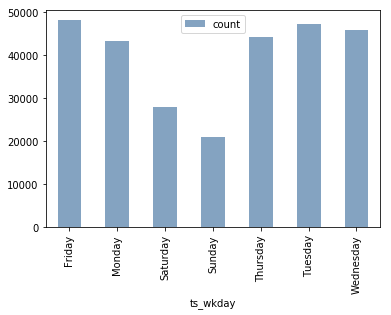

In [22]:
temp = df.groupby('ts_wkday').count().sort('ts_wkday').toPandas()
temp.plot(kind='bar',x='ts_wkday', y='count',color=(0.2, 0.4, 0.6, 0.6));

People dont tend to listen music on weekends. Maybe because of they dont commute, or maybe they sociliaze

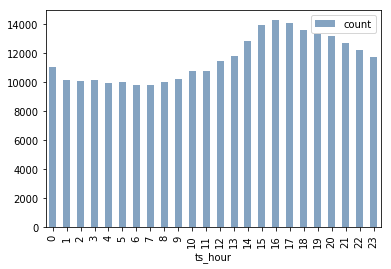

In [23]:
temp = df.groupby('ts_hour').count().sort('ts_hour').toPandas()
temp.plot(kind='bar',x='ts_hour', y='count',color=(0.2, 0.4, 0.6, 0.6));

The most active hours are 15-16-17-18 hr.

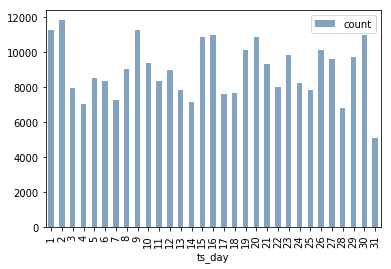

In [24]:
temp = df.groupby('ts_day').count().sort('ts_day').toPandas()
temp.plot(kind='bar',x='ts_day', y='count',color=(0.2, 0.4, 0.6, 0.6));

Day of month doesnt tell much thing.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
# lets check what it looks like for a single user / This user has Cancellation.
df.where(df.userId == 12).select(['userId','sessionId','itemInSession','page','ts','level']).show()

+------+---------+-------------+-----------+-------------+-----+
|userId|sessionId|itemInSession|       page|           ts|level|
+------+---------+-------------+-----------+-------------+-----+
|    12|       11|            1|       Home|1538533887000| free|
|    12|       11|            2|   NextSong|1538534032000| free|
|    12|       11|            3|   NextSong|1538534284000| free|
|    12|       11|            4|Roll Advert|1538534719000| free|
|    12|       11|            5|   NextSong|1538534995000| free|
|    12|       11|            6| Add Friend|1538534996000| free|
|    12|       11|            7|   NextSong|1538535186000| free|
|    12|       11|            8|   NextSong|1538535442000| free|
|    12|       11|            9|   NextSong|1538537680000| free|
|    12|       11|           10|   NextSong|1538537843000| free|
|    12|       11|           11|   NextSong|1538538176000| free|
|    12|       11|           12|   NextSong|1538538290000| free|
|    12|       11|       

In [26]:
# values of page features
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [27]:
temp = df.filter(df_val["page"] == "Cancellation Confirmation").count()
print(f'{temp} user cancelled their account')

52 user cancelled their account


In [28]:
# create a list for churn users
churn_user_df = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_user_list = [user["userId"] for user in churn_user_df.collect()]

In [29]:
# create a column for churn
df = df.withColumn("churn", df.userId.isin(churn_user_list))

In [30]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------+------+--------+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|ts_hour|ts_day|ts_wkday|churn|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------+------+--------+-----+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|      0|     1|  Monday|false|
+--------------+---------+---------+------+-------------+--------+---------+-----+------

### Visualize Churn vs Gender

In [37]:
# show gender difference in churn
gender_data = df.dropDuplicates(['userId']).groupby(['gender','churn']).count().toPandas()

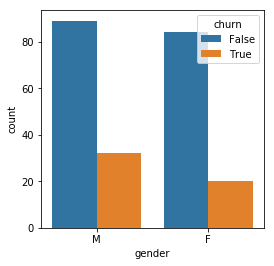

In [40]:
# plot gender effect on churn
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot( x="gender",y="count", hue="churn", data=gender_data,ax=ax);

### Visualize Churn vs Subscription

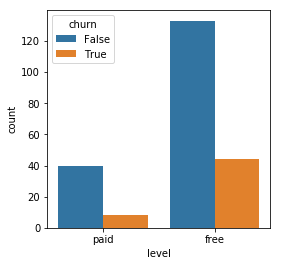

In [43]:
# show subscription difference in churn
level_data = df.dropDuplicates(['userId']).groupby(['level','churn']).count().toPandas()
# plot subscription effect on churn
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot( x="level",y="count", hue="churn", data=level_data,ax=ax);### Visualize Churn vs Gender

In [69]:
temp = level_data[(level_data['level'] == 'free') & (level_data['churn'] == True) ]['count'].values[0] \
/ level_data.groupby('level').sum().iloc[0][1]
print(f'free/churn ratio: {temp}')

free/churn ratio: 0.24858757062146894


In [70]:
temp = level_data[(level_data['level'] == 'paid') & (level_data['churn'] == True) ]['count'].values[0] \
/ level_data.groupby('level').sum().iloc[1][1]
print(f'paid/churn ratio: {temp}')

paid/churn ratio: 0.16666666666666666


Paid users are less likely to churn compared to free users.

### Visualize Churn vs Number of Page Visits

In [136]:
page_data = df.select(["page","churn"]).groupby([ "page","Churn"]).count().sort("count").toPandas()

In [137]:
page_data = page_data[~(page_data['page'].isin(["NextSong","Cancel","Cancellation Confirmation"]))] # Next Song is super common, cancels are churns

In [145]:
def myNormalizer(df, column):
    x = df[[column]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df['count'] = x_scaled
    return df

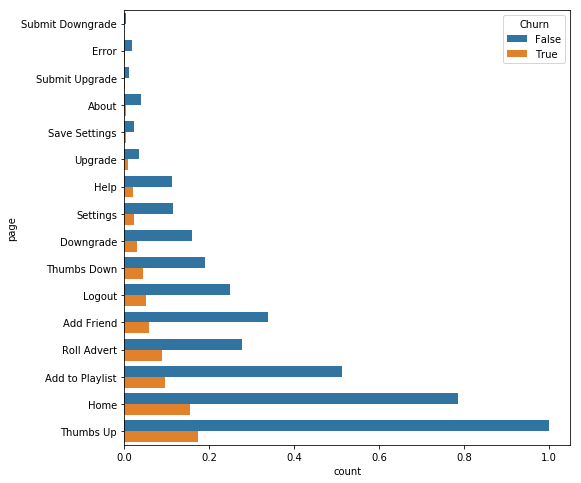

In [139]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="count",y="page", hue="Churn", data=page_data,ax=ax);

RollAdvert, Thumbs Down, Error, Use of Playlist and Friending pages may have effect on Churn

### Analyze Churned Users

In [140]:
#page_dataC = df.filter(df["churn"] == True).select(["page"]).groupby([ "page"]).count().sort("count").toPandas()

### Analyze Churn vs Timestamp

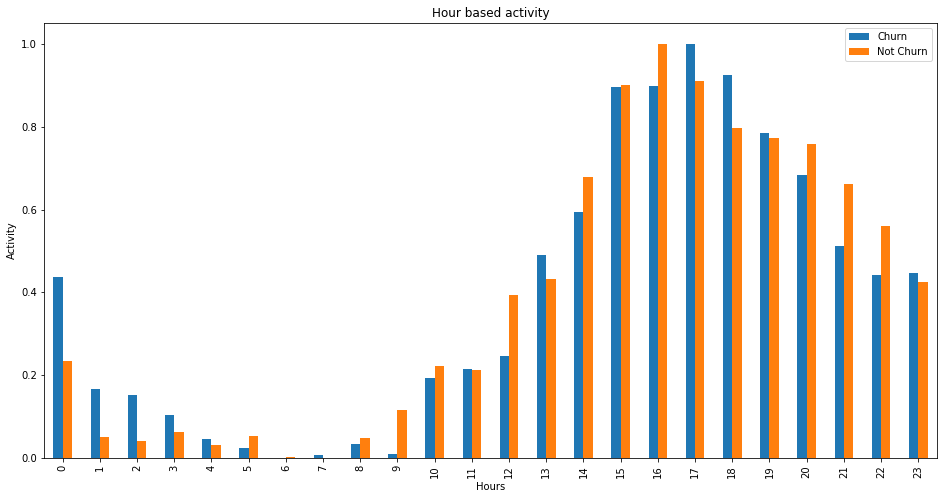

In [284]:
hour_data = df.filter(df["churn"] == True).select(["ts_hour"]).groupby([ "ts_hour"]).count().sort("ts_hour").toPandas()
hour_data_C = myNormalizer(hour_data, 'count')
hour_data = df.filter(df["churn"] == False).select(["ts_hour"]).groupby([ "ts_hour"]).count().sort("ts_hour").toPandas()
hour_data_NC = myNormalizer(hour_data, 'count')
plotdata = pd.DataFrame({
    "Churn": hour_data_C['count'].values,
    "Not Churn":hour_data_NC['count'].values
    }, 
    index=hour_data_C.index.values
)
plotdata.plot(kind="bar", figsize=(16,8));
plt.title("Hour based activity");
plt.xlabel("Hours");
plt.ylabel("Activity");

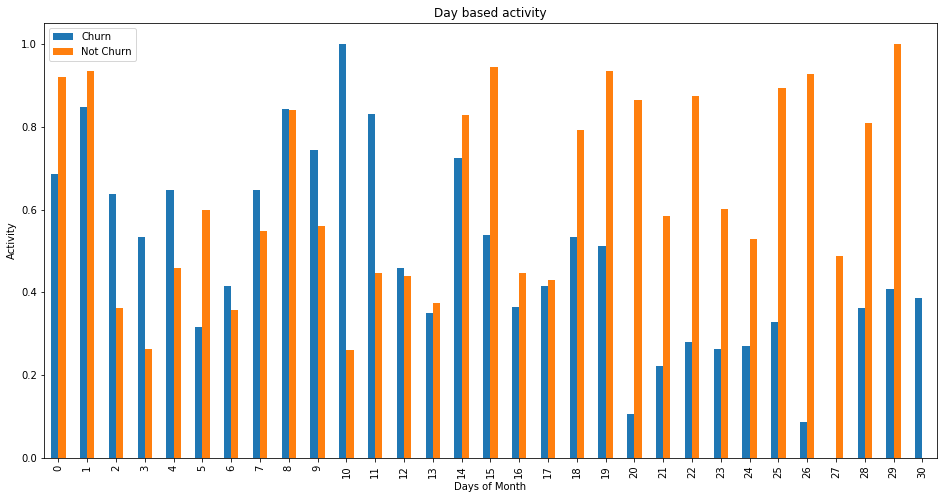

In [285]:
day_data = df.filter(df["churn"] == True).select(["ts_day"]).groupby([ "ts_day"]).count().sort("ts_day").toPandas()
day_data_C = myNormalizer(day_data, 'count')
day_data = df.filter(df["churn"] == False).select(["ts_day"]).groupby([ "ts_day"]).count().sort("ts_day").toPandas()
day_data_NC = myNormalizer(day_data, 'count')
plotdata = pd.DataFrame({
    "Churn": day_data_C['count'].values,
    "Not Churn":day_data_NC['count'].values
    }, 
    index=day_data_C.index.values
)
plotdata.plot(kind="bar", figsize=(16,8));
plt.title("Day based activity");
plt.ylabel("Activity");
plt.xlabel("Days of Month");

Churn activities are more common on the first half of the month.

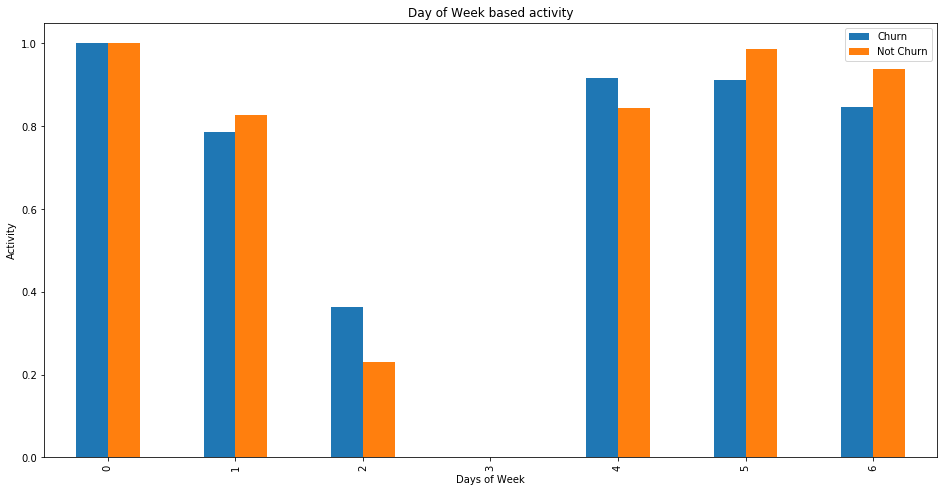

In [286]:
wk_data = df.filter(df["churn"] == True).select(["ts_wkday"]).groupby([ "ts_wkday"]).count().sort("ts_wkday").toPandas()
wk_data_C = myNormalizer(wk_data, 'count')
wk_data = df.filter(df["churn"] == False).select(["ts_wkday"]).groupby([ "ts_wkday"]).count().sort("ts_wkday").toPandas()
wk_data_NC = myNormalizer(wk_data, 'count')
plotdata = pd.DataFrame({
    "Churn": wk_data_C['count'].values,
    "Not Churn":wk_data_NC['count'].values
    }, 
    index=wk_data_C.index.values
)
plotdata.plot(kind="bar", figsize=(16,8));
plt.title("Day of Week based activity");
plt.ylabel("Activity");
plt.xlabel("Days of Week");

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Use "Subscription Level" as First Feature

In [252]:
df_level = df.dropDuplicates(['userId']).sort('userId').select(['userId','level'])
df_level = df_level.replace(['paid','free'], ['1', '0'], 'level')
df_level = df_level.withColumn('level', df_level.level.cast("int"))

### Use "Thumbs Down" as Second Feature

In [216]:
df_thumbsdown = df.where(df.page=='Thumbs Down').groupby(['userId'])\
    .agg(count(col('page')).alias('ThumbsDowns')).orderBy('userId').select(['userId','ThumbsDowns'])

### Use "Roll Advert" as Third Feature

In [212]:
df_rollAd = df.where(df.page=='Roll Advert').groupby(['userId'])\
    .agg(count(col('page')).alias('RollAdv')).orderBy('userId').select(['userId','RollAdv'])

### Use "Errors" as Fourth Feature

In [213]:
df_errors = df.where(df.page=='Error').groupby(['userId'])\
    .agg(count(col('page')).alias('Errors')).orderBy('userId').select(['userId','Errors'])

### Use "Friends" as Fifth Feature

In [214]:
df_friends = df.where(df.page=='Add Friend').groupby(['userId'])\
    .agg(count(col('page')).alias('Friends')).orderBy('userId').select(['userId','Friends'])

### Use "Number of Songs" as Sixth Feature

In [223]:
df_songs = df.where(df.song!='null').groupby('userId') \
    .agg(count(df.song).alias('SongsPlayed')).orderBy('userId').select(['userId','SongsPlayed'])

### Create Features DataFrame

In [255]:
df_features = df.dropDuplicates(['userId']).select(['userId','churn'])

In [256]:
df_features = df_features.join(df_level, 'userId')
df_features = df_features.join(df_thumbsdown, 'userId')
df_features = df_features.join(df_rollAd, 'userId')
df_features = df_features.join(df_errors, 'userId')
df_features = df_features.join(df_friends, 'userId')
df_features = df_features.join(df_songs, 'userId')
#df_features.show()

In [287]:
df_features.show()

+------+-----+-----+-----------+-------+------+-------+-----------+
|userId|churn|level|ThumbsDowns|RollAdv|Errors|Friends|SongsPlayed|
+------+-----+-----+-----------+-------+------+-------+-----------+
|   100|  0.0|  1.0|       27.0|   25.0|   3.0|   49.0|     2682.0|
|100001|  1.0|  0.0|        2.0|   14.0|   1.0|    2.0|      133.0|
|100004|  0.0|  0.0|       11.0|   86.0|   2.0|   19.0|      942.0|
|100013|  1.0|  0.0|       15.0|   39.0|   2.0|   28.0|     1131.0|
|100015|  1.0|  0.0|        8.0|   69.0|   1.0|   14.0|      800.0|
|100016|  0.0|  1.0|        5.0|   16.0|   1.0|   13.0|      530.0|
|100021|  1.0|  0.0|        5.0|   30.0|   2.0|    7.0|      230.0|
|100022|  1.0|  0.0|       20.0|  115.0|   1.0|   11.0|      681.0|
|100025|  1.0|  1.0|        7.0|   30.0|   1.0|    3.0|      490.0|
|   101|  1.0|  0.0|       16.0|    8.0|   3.0|   29.0|     1797.0|
|   104|  0.0|  0.0|       17.0|   23.0|   1.0|   23.0|     1781.0|
|   105|  1.0|  0.0|        6.0|    2.0|   2.0| 

In [263]:
df_features.dtypes

[('userId', 'string'),
 ('churn', 'boolean'),
 ('level', 'int'),
 ('ThumbsDowns', 'bigint'),
 ('RollAdv', 'bigint'),
 ('Errors', 'bigint'),
 ('Friends', 'bigint'),
 ('SongsPlayed', 'bigint')]

In [265]:
# convert data type of columns into float
for feature in df_features.columns[1:]:
    df_features = df_features.withColumn(feature,df_features[feature].cast('float'))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [267]:
train, test = df_features.randomSplit([0.8, 0.2], seed=42)

### Logistic Regression

In [268]:
assembler = VectorAssembler(inputCols=df_features.columns[2:],outputCol='featuresassemble')
scaler = StandardScaler(inputCol="featuresassemble", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed", seed=42)

In [269]:
pipeline_lr = Pipeline(stages=[assembler, scaler, indexer, lr])

In [280]:
# Grid Search parameters for logistic regression
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.maxIter, [10, 30]) \
    .addGrid(lr.regParam, [0.0, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()


crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=4)

In [281]:
cvModel_lr = crossval_lr.fit(train)

In [298]:
cvModel_lr.avgMetrics

[0.6671682883679787,
 0.6671682883679787,
 0.656811882647796,
 0.6678162317558602,
 0.6812929382279227,
 0.6812929382279227,
 0.656811882647796,
 0.653045849918915]

In [306]:
# test performance
results_lr = cvModel_lr.transform(test)
print("F1 Score of Logistic Regression:", BinaryClassificationEvaluator().evaluate(results_lr))

F1 Score of Logistic Regression: 0.7592592592592592


### Random Forest

In [275]:
pipeline_rf = Pipeline(stages=[assembler, scaler, indexer, stringIndexer, rf])

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees,[10, 30]) \
    .build()


crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [276]:
cvModel_rf = crossval_rf.fit(train)

In [300]:
cvModel_rf.avgMetrics

[0.6427128427128427, 0.6212713873428158]

In [307]:
results_rf = cvModel_rf.transform(test)

In [308]:
print("F1 Score of Random Forest:", BinaryClassificationEvaluator().evaluate(results_rf))

F1 Score of Random Forest: 0.8703703703703703


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.